In [26]:
# -*- coding: utf-8 -*-
import argparse
import os
import pickle as pkl
import random

import numpy as np
import torch
# import torch.distributed
import wandb
from ase.units import GPa

from mattersim.datasets.utils.build import build_dataloader
from mattersim.forcefield.m3gnet.scaling import AtomScaling
from mattersim.forcefield.potential import Potential
from mattersim.utils.atoms_utils import AtomsAdaptor
from mattersim.utils.logger_utils import get_logger

from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import pandas as pd

In [2]:
atoms_val = AtomsAdaptor.from_file(filename="../../data/benchmarks/val_water_1593_eVAng.xyz")
energies = []
forces = [] 
for atoms in atoms_val:
    energies.append(atoms.get_potential_energy() / len(atoms)) 
    forces.append(atoms.get_forces())

print(f"Processed {len(atoms_val)} validation data")

val_dataloader = build_dataloader(
    atoms_val,
    energies,
    forces,
    pin_memory=True,
    is_distributed=False,
    shuffle=False,
    batch_size=16
)

potential = Potential.from_checkpoint(
    load_path="./results/best_model.pth",
    load_training_state=False,
    long_range=True
)

predicted_energies, predicted_forces, _, charges = potential.predict_properties(
    val_dataloader,
    include_forces=True,
    include_stresses=False
)

predicted_energies = np.array(predicted_energies) / len(atoms)

true_energies, true_forces = energies, forces

Processed 160 validation data


In [24]:
element_list = []
for i in range(len(atoms_val)):
    element_list += atoms_val[i].get_chemical_symbols()

In [35]:
df = pd.DataFrame({"Atoms": element_list, "Predicted Charges": charges})
df

,Atoms,Predicted Charges
0,O,-2.719077
1,H,1.952712
2,H,1.563780
3,O,-2.920070
4,H,1.401454
...,...,...
30715,H,1.383225
30716,H,1.359742
30717,O,-2.868552
30718,H,1.463303


10.436353708989918


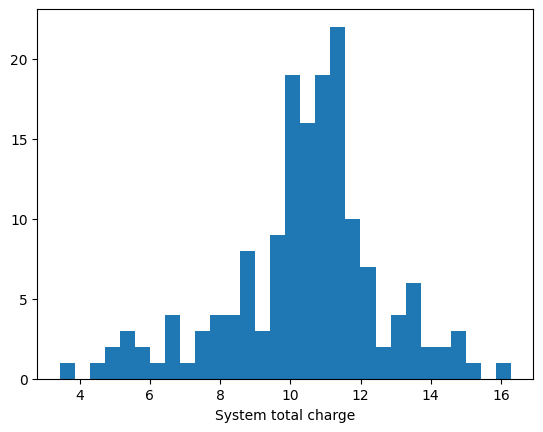

In [109]:
count = 0
system_charge = []
for i in atoms_val:
    system_charge.append(sum(df["Predicted Charges"].iloc[count:count+len(i)]))
    count += len(i)

plt.hist(np.array(system_charge), bins=30)
plt.xlabel("System total charge")
print(np.array(system_charge).mean())

0.16306802670296747


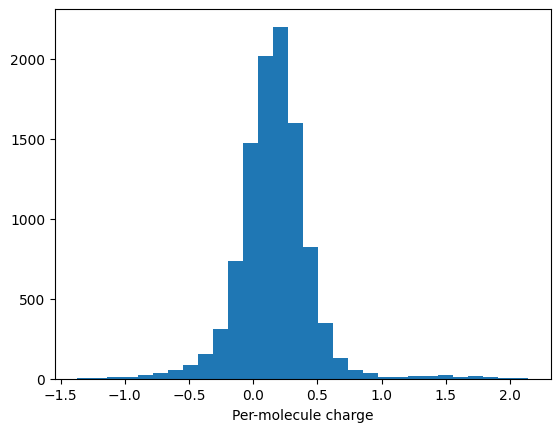

In [110]:
molecule_charge = []
for i in range(0, len(df), 3):
    molecule_charge.append(sum(df["Predicted Charges"].iloc[i:i+3]))

plt.hist(np.array(molecule_charge), bins=30)
plt.xlabel("Per-molecule charge")

print(np.array(molecule_charge).mean())